# Data 607 Project Proposal
## Image Classification for Amazon Products

Team - YongPeng Fu, Stuart Finley, Sneha Arora

**Purpose**
We will use our own customized web scraping tool to download thousands of images from Amazon for a range of human wearable products, including Earbuds, VR sets, Fitness trackers, Hearing Aids, Watches, Sunglasses, and Hats. Our purpose is to build a model that can accurately classify the products in the images.

**Questions to Analyse**
1. How do conventional machine learning techniques compare to neural networks for image analysis and classification?
2. What are the effects of using dimensionality reduction for image classification?
3. Can we come to a final best-suited model to tag images for human wearable products? 
							
**Methodology**
Data preprocessing is required prior to building models, and the images need labelling based on the product category to which they belong. Currently, the images reside in their respective folders, where the folder will be the label name for the image. For each image, colours will be removed. In addition, Images will need to be resized to a standard size, and pixel values normalized to a range of [0, 1]. Then, the data is split into training and validation sets, where the training set is to be used to train the model, and the validation set is used to evaluate the performance of the model during training.
As an exploration step, we will first use conventional machine learning models including logistic regression, K-nearest neighbours (KNN), support vector machines (SVM), Gaussian Bayes Classifier, and tree-based classifiers. These models will be trained using the labelled images, and their performance will be evaluated on a validation dataset. 
To reduce computational power and improve the efficiency of our models,  dimensionality reduction will be implemented using Principal Component Analysis (PCA), where the complexity of the image data is reduced through the identification of the most important pixels. We can then evaluate the effectiveness of using dimensionality for image classification by applying each trained model to validation sets.
Our team will explore the use of deep learning methods like Convolutional Neural Networks (CNN) to classify images. These models apply convolutional filters to the input image, which extract features at different spatial scales. The extracted features are then fed into a series of fully connected layers that perform the classification task. The model's output is a softmax layer that predicts the probability distribution over the product categories.
CNN is explored later in this course, but our team will do preliminary work to build a CNN model for image classification, which we can refine further using the additional materials we learn. 

**Challenges**
	Our team's challenge is the number of images available for training the model in each class. For each product search on Amazon, around 330 images are returned. It is estimated that for a good image classification model, ~500 images [1]  are required for training. To overcome this hurdle, our training data may need to be augmented by randomly cropping, rotating, brightening, or warping the original images. This can effectively increase the size of our training sets for each class.


**References**

[1] Falzon, G., Meek, P., & Shahinfar, S. (2020, March 19). "How many images do I need?" understanding how sample size per class affects deep learning model performance metrics for balanced designs in autonomous wildlife monitoring. Retrieved March 22, 2023, from https://www.sciencedirect.com/science/article/abs/pii/S1574954120300352 


## Outline of the project
First we will try a range of conventional machine learning models like Random Forest Classifier, KNN, Decision Tree Classifier, and Naive Bayes classifier. Later on we will also implement Deep Learning like CNN.

The overall layout for this analysis is:
1. import all required packages
2. Load the data and label each image
3. Visualialize some figures and process them
4. Try differetnt machine learning modesl, find the best hypter parameters, and evaluate respective performance
5. Use the trained model to do some prediction

## Load required packages

In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

from pathlib import Path
import os
import re

#need to pip install opencv-python
import cv2
from skimage.color import rgb2gray #convert RGB to gray color

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# #Access Google Drive from Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')

# #Remove some unnecessary folder since I will move everyting to colab
# import shutil

# # Deleting an non-empty folder
# dir_path = ["./Images+augmentation/ImageFolder2/" + classes +"/augmented_rotate" for classes in class_names]
# for every_path in dir_path:
#     shutil.rmtree(every_path, ignore_errors=True)
#     print("Deleted '%s' directory successfully" % every_path)

In [4]:
#Get the total classes we have
class_names = [class_name for class_name in os.listdir("./Images+augmentation/ImageFolder2") if not class_name.startswith(".")]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)
print(f"We have in total {nb_classes} different classes."+
      f"\nAnd they are:\n {', '.join(classes for classes in class_names)}.")

We have in total 11 different classes.
And they are:
 tshirt, sunglasses, watches, speaker, chair, shorts, phone, earbuds, hat, shoes, bottle.


## Explore cv2 package

The original image has shape of (218, 214, 3) with datatype of uint8
The image after converting into gray color has shape of (218, 214) with datatype of float64
The image after resizing has shape of (150, 150, 3) with datatype of uint8


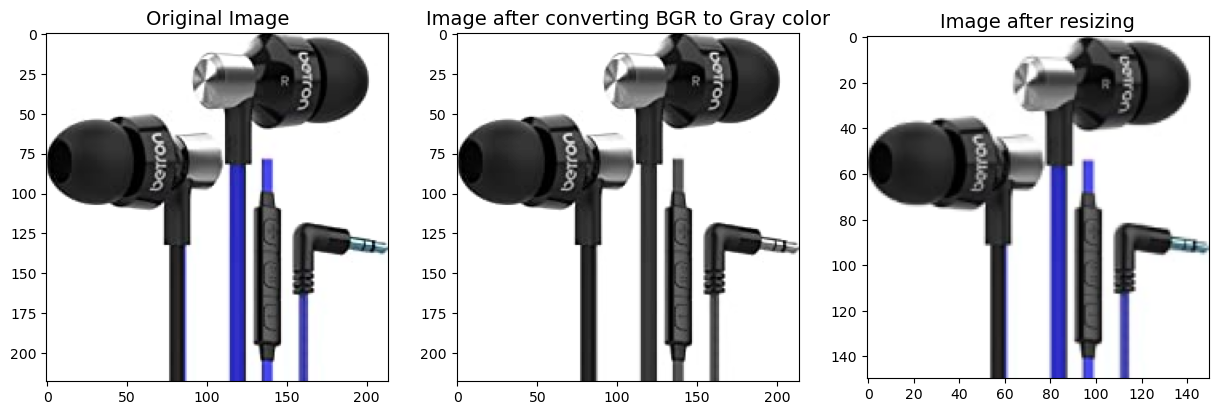

In [5]:
# '''
# OS.walk() generate the file names in a directory tree by walking the tree either top-down or bottom-up.
# For each directory in the tree rooted at directory top (including top itself), 
# it yields a 3-tuple (dirpath, dirnames, filenames).
# For example, we have 12 folder in ./images, it will loop through 13 times = root + 12 folders
# Read more in https://www.geeksforgeeks.org/os-walk-python/
# '''
# class_name = []
# for root, dirs, files in os.walk("./images", topdown = True):
#     for name in files:
#         print(os.path.join(root, name))

# for i in range(10):
#     plt.imshow(images[i].astype('uint8'))

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
#Read in one image and show them
test_img1 = cv2.imread("./Images+augmentation/ImageFolder2/earbuds/615MxN+QWzL.jpg")
#The original image
print(f"The original image has shape of {test_img1.shape} with datatype of {test_img1.dtype}")
axes[0].imshow(test_img1)
axes[0].set_title("Original Image", fontsize=14)
#After change the color space from BGR to RGB
'''
When the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red). 
On the other hand, in Pillow, the order of colors is assumed to be RGB (red, green, blue).
Therefore, if you want to use both the Pillow function and the OpenCV function, you need to convert BGR and RGB.
'''
'''
When reading a color image file, OpenCV imread() reads as a NumPy array ndarray of 
row (height) x column (width) x color (3). The order of color is BGR (blue, green, red).
read more in https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/

test_img2 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
'''
'''
Reducing computational demand:
With interest in minimizing cost, it is best to only retain the information required for the task in question.
Common ways to carry out this step include reducing image size and removing color. 
In many cases, such a level of detail is not needed for the model to perform well.

For example, when comparing cats and dogs, color is not really a deciding factor. 
You can easily build a model that distinguishes between the two species without colored images.

Here, the Skimage package is used to remove color from the cat image.
'''
test_img2 = rgb2gray(test_img1)
axes[1].imshow(test_img2, cmap=plt.cm.gray)
axes[1].set_title("Image after converting BGR to Gray color", fontsize=14)
print(f"The image after converting into gray color has shape of {test_img2.shape} with datatype of {test_img2.dtype}")
'''
OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
The aspect ratio is preserved when we specify the scaling factor.
'''
test_img3 = cv2.resize(test_img1, (150,150))
axes[2].imshow(test_img3)
axes[2].set_title("Image after resizing", fontsize=14)
print(f"The image after resizing has shape of {test_img3.shape} with datatype of {test_img3.dtype}")
plt.show()

## Load Data
Based on previous test, we can do the following steps to reduce the computational demand:
1. Removing color (potentially)
2. Reducing image size

In [6]:
#Load the data from each folder
def load_image_from_folder(root_dir, max_img_perclass = 4000):

    images = []
    labels = []
    IMAGE_SIZE = (150, 150)

    for folder in os.listdir(root_dir):
        #Because there are some configure file also sitting there  
        if folder.startswith("."):
            continue
        label = class_names_label[folder]
        total_img_perclass = 0
        for root, dirs, files in os.walk(os.path.join(root_dir, folder), topdown = True):
            # Get the path name of the image
            for file in files:
                img_path = os.path.join(root,file)
                #open and resize the image, read in as 3d array
                '''
                The reason we add try except is because some iamges just cannot be read in to cv2
                for example this one: ./updated images/watches/712+lS1mk-L._AC_UL320_.jpg
                I dont know why.

                Also, there are some corrupted images like this one: ./updated images/watches/814cT4PAxeL._AC_UL320_.jpg
                However, cv2 wont allow us to capture this images. We will still keep them in our image pool,
                because they dont really cause any issue.

                If you do want learn more read https://medium.com/joelthchao/programmatically-detect-corrupted-image-8c1b2006c3d3
                and
                https://scikit-image.org/
                '''
                try:
                    image = cv2.imread(img_path)
                    #cv2.cvtColor() method is used to convert an image from one color space to another.
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
                    #is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
                    #The aspect ratio is preserved when we specify the scaling factor.
                    image = cv2.resize(image, IMAGE_SIZE)
                except:
                    continue
                
                total_img_perclass += 1
                if total_img_perclass > max_img_perclass:
                    break
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
    # The original dtypes of image is uint8 (Unsigned integer type, from 0 to 18_446_744_073_709_551_615)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return ((images, labels))

In [7]:
images, labels = load_image_from_folder('./Images+augmentation/ImageFolder2',max_img_perclass = 600)

#Shuffle arrays or sparse matrices in a consistent way.
#This is a convenience alias to resample(*arrays, replace=False) to do random permutations of the collections.
#otherwise imaages are grouped all together based on their classes
images_r, labels_r = shuffle(images, labels, random_state=25)

Corrupt JPEG data: 1955 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2472 extraneous bytes before marker 0xc4
Corrupt JPEG data: 897 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1003 extraneous bytes before marker 0xc4
Corrupt JPEG data: 1312 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code


## How to find duplicated images
Since we are pulling more images from Amazon Country, maybe there are some duplicated images. We will write a function to find those images and only keep one of duplicated images.

This is done by leveraing the fact that duplicated images has very similar naming.

## Visualization

How many images in each class?


,,,,,,,,,,,
Class,bottle,chair,earbuds,hat,phone,shoes,shorts,speaker,sunglasses,tshirt,watches
Total Amount,600,600,600,600,600,600,600,600,600,600,600


Each image size is: (150, 150).


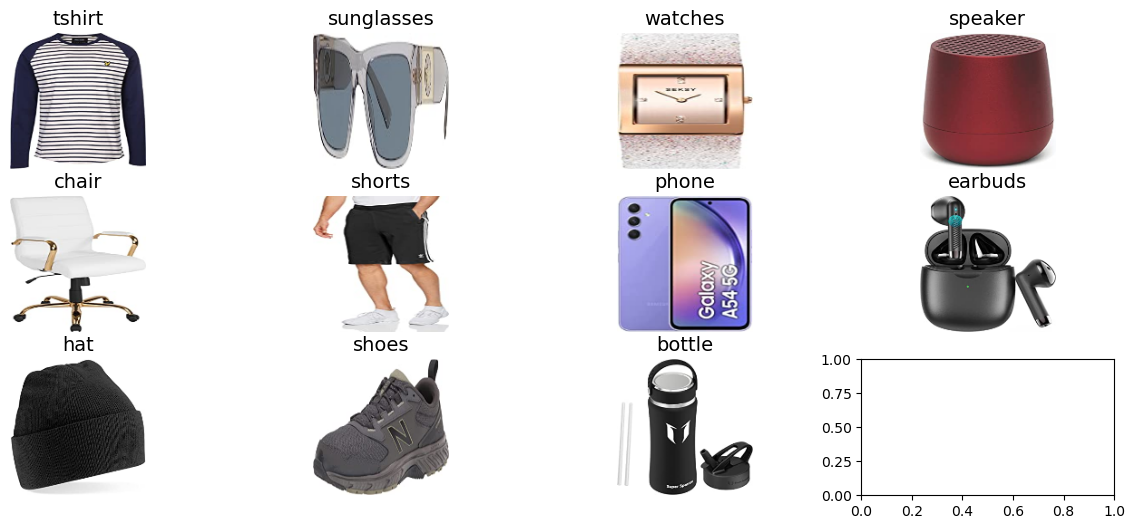

In [8]:
'''
How many images in each class?
'''
print("How many images in each class?")
class_name, count_name = np.array(np.unique(np.array(class_names)[labels_r], return_counts=True))
total_images = pd.DataFrame((class_name, count_name), 
             index = ["Class", "Total Amount"], columns = ['']*len(class_name))
display(total_images)

print(f"Each image size is: {IMAGE_SIZE}.")

#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    x = images_r[labels_r == i][0].astype('uint8')
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

## Preprocessing
Normalization is a common step of image pre-processing and is achieved by simply dividing images by 255.0. This is essential to maintain the pixels of all the images within a uniform range.

The shape of images is in 4 dimensions like (44000, 150, 150, 3)=(nsamples, nx, ny, nrgb) , meaing there are total 44000 images and each image has (150, 150, 3) shape.

1. nrgb = 3 means there are 3 channels to make the image colourful. However, as demonstrated before, we dont really need color to differentiate image category. We will convert rgb to gray to reduce computational demond then.
2. The Sklearn machine leraning models are expecting 2 dimensions, with row as each image information.

Read more:
- https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/
- https://towardsdatascience.com/3-things-you-need-to-know-before-working-with-images-in-machine-learning-6a2ab6f6b822#:~:text=Running%20machine%20learning%20models&text=Convolutional%20neural%20networks%20only%20function,common%20practice%20in%20computer%20vision
- https://towardsdatascience.com/3-things-you-need-to-know-before-working-with-images-in-machine-learning-6a2ab6f6b822#:~:text=Running%20machine%20learning%20models&text=Convolutional%20neural%20networks%20only%20function,common%20practice%20in%20computer%20vision.

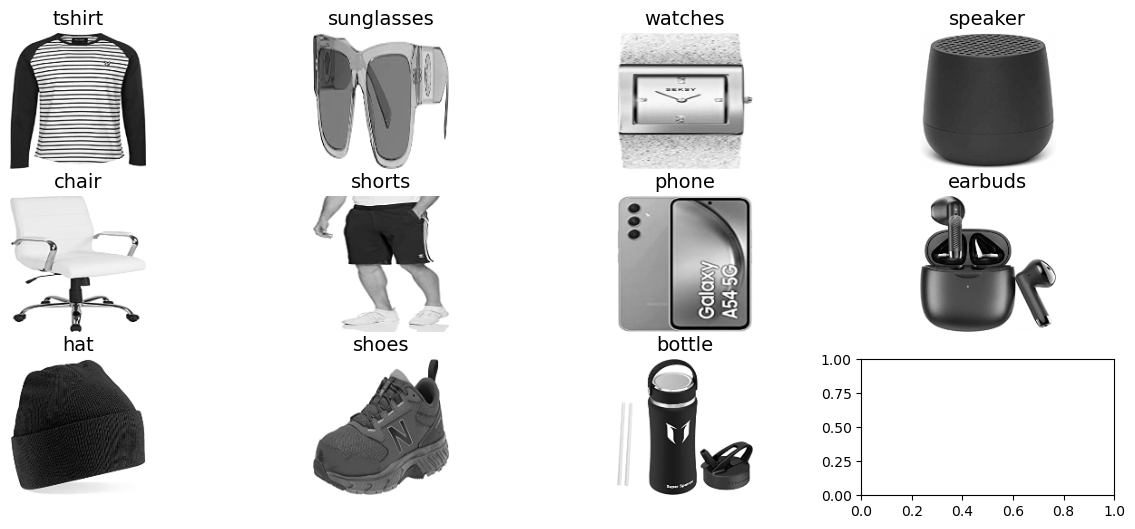

In [9]:
#1: remove colours
images_r_g = np.zeros(images_r.shape[0:3])
for i in range(images_r.shape[0]):
    images_r_g[i] = rgb2gray(images_r[i])
    
#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    #x = images_r[labels_r == i][0].astype('uint8')
    x = images_r_g[labels_r == i][0]
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

In [11]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

#reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

#look at the shaoe of training and testing
X_train_norm.shape, X_test_norm.shape

((5280, 22500), (1320, 22500))

## Implementing different machine learning models
1. Logistic regression
2. K-Nearest Neighbours
3. LDA / QDA / Gaussian Naive Bayes
4. PCA (will be used to combine with other method)
5. Support Vector Machine
6. Trees (DecisionTreeClassifier, Bagging and Random Forests, Boosting, Bayesian Additive Regression Trees (BART))
7. Neural Networks

Each method we need to do cross validation (Kfold), hyper parameter tunning methods, or CVGridSearch. The following is a diagram of k-fold cross-validation.
![k-fold cross validation](./Archive/k-fold-cross-validation.png)

### Logistic regression (NOTE, to save time, I only use 600 images from each category)
We will fit the model and compute the score 5 consecutive times (with different splits each time). Because our samples are balanced across target classes ence the accuracy and the F1-score are almost equal.

In [12]:
import warnings
warnings.filterwarnings("ignore")
'''
The reason I want to ignore any warnings is because we got the following warning:
ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

There are a few solutions to this:
    Increase the number of iterations;
    Try a different optimizer;
    Scale your data;
    Add engineered features;
    Data pre-processing;
    Add more data.

We did try a few of them, but we have to balance between computation power and finding the best model.
Since our single computer is not powerful enough, we can only try as much as we can.
'''

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for logistic regression
scores = cross_val_score(LogisticRegression(), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy")
print("The accuracy rate using logistic regression is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))
#The accuracy rate using logistic regression is: 0.63 accuracy with a standard deviation of 0.01

The accuracy rate using logistic regression is: 0.62 accuracy with a standard deviation of 0.01


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

#Read pipelining in https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

# 3: Using a cross-validated grid search (GridSeachCV), find an optimal LogisticRegression fit to the training set.
parameters = {'solver':("newton-cg", "sag", "saga"), 'max_iter':(100, 500)}
lr = LogisticRegression()
#n_jobs = -1: use all available processors
glr = GridSearchCV(lr, parameters, scoring='accuracy', cv= 5, n_jobs = -1)
glr.fit(X_train_scaled, y_train)
print("The best values for solver and max_iter are", glr.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using logistic regression is {glr.score(X_test_scaled, y_test):.2f}.")


### Tree (NOTE, to save time, I only use 600 images from each category)
We will try a few different trees to do classification:
1. DecisionTreeClassifier
2. Bagging for classification tree
3. Random Forests for classification tree
4. Boosting (only for regression)
5. Bayesian Additive Regression Trees (BART) (only for regression)

#### DecisionTreeClassifier

In [16]:
import warnings
warnings.filterwarnings("ignore")

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for DecisionTreeClassifier
criteria = "gini"
max_depth = 6

scores = cross_val_score(DecisionTreeClassifier(criterion=criteria, random_state=2023,max_depth=max_depth), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy")
print("The accuracy rate using DecisionTreeClassifier is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))

The accuracy rate using DecisionTreeClassifier is: 0.51 accuracy with a standard deviation of 0.01


In [ ]:
'''
Decide which parameters to finetune, you can look at the following articles:
https://www.datacamp.com/tutorial/decision-tree-classification-python
https://www.projectpro.io/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python
https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
#https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
'''
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

# To build a tree, we could use 'gini' or 'entropy' as split criterion at each node.
#max_depth indicates how deep the tree can be. The deeper the tree, 
#the more splits it has and it captures more information about the data.
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12, 14, 16, 18, 20]
parameters = {'criterion':criterion, 'max_depth':max_depth}
dtc = DecisionTreeClassifier()

#Read pipelining in https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# Using a cross-validated grid search (GridSeachCV), find an optimal DecisionTreeClassifier fit to the training set.
#n_jobs = -1: use all available processors
gdtc = GridSearchCV(dtc, parameters, scoring='accuracy', cv= 5, n_jobs = -1)
gdtc.fit(X_train_scaled, y_train)
print("The best values for criterion and max_depth are", gdtc.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using DecisionTreeClassifier is {gdtc.score(X_test_scaled, y_test):.2f}.")

In [ ]:
'''
Alternatively, we will use repeated  𝑘 -fold cross validation to find the best parameters:
'''
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

max_depths = np.arange(2, 22, 2)
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html
'''
Try gini first.
'''
n_splits = 5
n_repeats = 40
accs_val = np.zeros((n_splits*n_repeats, len(max_depths)))
#Repeats K-Fold n times with different randomization in each repetition.
for j, k in enumerate(max_depths):
    #n_splits: Number of folds
    #basically it says create a 5 fold cross validator and repeat each cross validaiton 40 times
    #it is cross-validation + repeat for each cross-validation
    rkcv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2023)
    #split(X[, y, groups]) Generates indices to split data into training and test set.
    splits = rkcv.split(X_train_scaled, y_train)
    
    # i = n_splits * n_repeats
    for i, (I_tr, I_val) in enumerate(splits):
        #for each max_depth, you have n_splits * n_repeats cross validation, n_splits * n_repeats accuracy
        model = DecisionTreeClassifier(max_depth=k, criterion='gini')
        model.fit(X_train_scaled[I_tr], y_train[I_tr])
        accs_val[i, j] = accuracy_score(y_train[I_val], model.predict(X_train_scaled[I_val]))

scores = accs_val.mean(axis=0)
max_depth_optimal = max_depths[scores.argmax()]

print("The max_depth in DecisionTreeClassifier that produces the highest accuracy is " + str(max_depth_optimal))
#The optimal value for max_depth is the one that maximize the accuracy rate, averaged over all 200 splittings.
plt.figure(figsize=(10,4))
plt.plot(max_depths, scores,'k', label="The average accuracy rate", lw=2)
plt.title("The average accuracy rate, averaged over all 200 splittings using DecisionTreeClassifier and gini criterion", 
          fontsize=10)
plt.xlabel('max_depth for DecisionTreeClassifier')
plt.ylabel('The average accuracy rate in DecisionTreeClassifier')
plt.vlines(max_depth_optimal, *plt.ylim(), colors="k", linestyles=":", 
           label=f"max. the average accuracy rate, $k$={max_depth_optimal}")
plt.legend()
plt.show()

#refit the model on the original training set and compute the accuracy rate on the test set.
model = DecisionTreeClassifier(max_depth=max_depth_optimal, criterion='gini')
model.fit(X_train_scaled, y_train)
test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
print(f"The accuracy rate on the test set using DecisionTreeClassifier and gini criterion is {test_accuracy:.2f}")

In [ ]:
'''
Alternatively, we will use repeated  𝑘 -fold cross validation to find the best parameters:
'''
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

max_depths = np.arange(2, 22, 2)
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html
'''
Try entropy then.
'''
n_splits = 5
n_repeats = 40
accs_val = np.zeros((n_splits*n_repeats, len(max_depths)))
#Repeats K-Fold n times with different randomization in each repetition.
for j, k in enumerate(max_depths):
    #n_splits: Number of folds
    #basically it says create a 5 fold cross validator and repeat each cross validaiton 40 times
    #it is cross-validation + repeat for each cross-validation
    rkcv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2023)
    #split(X[, y, groups]) Generates indices to split data into training and test set.
    splits = rkcv.split(X_train_scaled, y_train)
    
    # i = n_splits * n_repeats
    for i, (I_tr, I_val) in enumerate(splits):
        #for each max_depth, you have n_splits * n_repeats cross validation, n_splits * n_repeats accuracy
        model = DecisionTreeClassifier(max_depth=k, criterion='entropy')
        model.fit(X_train_scaled[I_tr], y_train[I_tr])
        accs_val[i, j] = accuracy_score(y_train[I_val], model.predict(X_train_scaled[I_val]))

scores = accs_val.mean(axis=0)
max_depth_optimal = max_depths[scores.argmax()]

print("The max_depth in DecisionTreeClassifier that produces the highest accuracy is " + str(max_depth_optimal))
#The optimal value for max_depth is the one that maximize the accuracy rate, averaged over all 200 splittings.
plt.figure(figsize=(10,4))
plt.plot(max_depths, scores,'k', label="The average accuracy rate", lw=2)
plt.title("The average accuracy rate, averaged over all 200 splittings using DecisionTreeClassifier and entropy criterion", 
          fontsize=10)
plt.xlabel('max_depth for DecisionTreeClassifier')
plt.ylabel('The average accuracy rate in DecisionTreeClassifier')
plt.vlines(max_depth_optimal, *plt.ylim(), colors="k", linestyles=":", 
           label=f"max. the average accuracy rate, $k$={max_depth_optimal}")
plt.legend()
plt.show()

#refit the model on the original training set and compute the accuracy rate on the test set.
model = DecisionTreeClassifier(max_depth=max_depth_optimal, criterion='entropy')
model.fit(X_train_scaled, y_train)
test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
print(f"The accuracy rate on the test set using DecisionTreeClassifier and entropy criterion is {test_accuracy:.2f}")

#### Bagging for classification tree

In [18]:
import warnings
warnings.filterwarnings("ignore")

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for Bagging classification tree
#We are using all features in RandomForestClassifier so we can mimic RandomForestClassifier in decsion tree.
all_features = images_r_g_scaled.shape[1]
scores = cross_val_score(RandomForestClassifier(max_features=all_features, random_state=2023), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy", n_jobs = 4)
print("The accuracy rate using Bagging classification tree is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))

The accuracy rate using Bagging classification tree is: 0.78 accuracy with a standard deviation of 0.01


In [ ]:
'''
Decision tree is an unstable classifier, which is often found to have high variance and low bias.
Therefore, we will use a bagging classifier for decision tree.

Read more in:
https://machinelearningmastery.com/bagging-ensemble-with-python/
https://vitalflux.com/bagging-classifier-python-code-example/
https://towardsdatascience.com/bagging-decision-trees-clearly-explained-57d4d19ed2d3
https://machinelearningmastery.com/bagging-ensemble-with-python/
'''
#We use RandomForestClassifier. and when max_features = numbe of total predictors, that is bagging
'''
We will finetune two hypteparameters for the bagging trees:
1: Number of trees
2: Number of samples
'''
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

#We are using all features in RandomForestClassifier so we can mimic RandomForestClassifier in decsion tree.
all_features = X_train_scaled.shape[1]

# To build a tree, we could use 'gini' or 'entropy' as split criterion at each node.
#max_depth indicates how deep the tree can be. The deeper the tree, 
#the more splits it has and it captures more information about the data.
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12, 14, 16, 18, 20]
n_estimators = [10, 50, 100, 500, 500, 1000, 5000]
## explore ratios from 10% to 100% in 10% increments
max_samples= np.arange(0.1, 1.1, 0.1)
parameters = {'n_estimators': n_estimators, 'max_samples':max_samples, 'criterion':criterion, 'max_depth':max_depth}

cls_bagging = RandomForestClassifier(max_features=all_features, random_state=2023)

#Read pipelining in https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# Using a cross-validated grid search (GridSeachCV), find an optimal DecisionTreeClassifier fit to the training set.
#n_jobs = -1: use all available processors
gcls_bagging = GridSearchCV(cls_bagging, parameters, scoring='accuracy', cv= 5, n_jobs = -1)
gcls_bagging.fit(X_train_scaled, y_train)
print("The best values for n_estimators, max_samples, criterion and max_depth are", gcls_bagging.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using bagging decession tree is {gcls_bagging.score(X_test_scaled, y_test):.2f}.")

#### Random Forecast
We will also do a hyperparameter tunning. They include the number of decision trees in the forest, the number of features considered by each tree when splitting a node, and maximum number of levels in tree. (The parameters of a random forest are the variables and thresholds used to split each node learned during training).

Read more in https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In this hyperparameter tunning, we will use **RandomizedSearchCV** instead of **GridSearchCV** to save time.

In [22]:
import warnings
warnings.filterwarnings("ignore")

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for Random Forecast
#We are using max_features that is close to square root of all features
sqrt_all_features = int(np.floor(np.sqrt(images_r_g_scaled.shape[1])))
scores = cross_val_score(RandomForestClassifier(max_features=sqrt_all_features, random_state=2023), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy", n_jobs = 4)
print("The accuracy rate using Random Forecast tree is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))

The accuracy rate using Random Forecast tree is: 0.78 accuracy with a standard deviation of 0.01


In [ ]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
'''
n_iter controls the number of different combinations to try
cv is the number of folds to use for cross validation
'''
grfc = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, 
                               cv = 5,random_state=2023, n_jobs = -1)
# Fit the random search model
grfc.fit(X_train_scaled, y_train)
print("The best values for RandomForestClassifier are", grfc.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using RandomForestClassifier is {grfc.score(X_test_scaled, y_test):.2f}.")

#### Boosting for classification tree
There are a few hyperparameters to tune:
1. The number of trees B. Unlike bagging and random forests, boosOng can overfit if B is too large, use cross-validaOon to select B.
2. The shrinkage parameter λ, controls the rate at which boosting learns. Typical values are 0.01 or 0.001, Very small λ can require using a very large value of B in order to achieve good performance.
3. The number d of splits in each tree, which controls the complexity of the boosted ensemble. Often d = 1 works well, in which case each tree is a stump, consising of a single split. In this case, the boosted stump ensemble is fiting an additive model, since each term involves only a single variable. More generally d is the interaction depth, and controls interaction the interaction order of the boosted model, since d splits can involve depth at most d variables.
4. learn more in https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [26]:
import warnings
warnings.filterwarnings("ignore")

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for GradientBoostingClassifier
scores = cross_val_score(GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, 
                                                    max_depth=4, random_state=2023), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy", n_jobs = -1)
print("The accuracy rate using GradientBoostingClassifier is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))

In [ ]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate shrinks the contribution of each tree by learning_rate
learning_rate = [0.01, 0.001]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
              'learning_rate': learning_rate}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbc = GradientBoostingClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
'''
n_iter controls the number of different combinations to try
cv is the number of folds to use for cross validation
'''
ggbc = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, 
                               cv = 5,random_state=2023, n_jobs = -1)
# Fit the random search model
ggbc.fit(X_train_scaled, y_train)
print("The best values for GradientBoostingClassifier are", ggbc.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using GradientBoostingClassifier is {ggbc.score(X_test_scaled, y_test):.2f}.")